# Proyek Klasifikasi Gambar: Sea Animals Dataset
- **Nama:** Isnaini Cahyaningrum
- **Email:** isnaini.anicn@gmail.com
- **ID Dicoding:** anicn14

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import random
from collections import defaultdict

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import tensorflow_decision_forests as tfdf
import tensorflowjs as tfjs

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

NotFoundError: c:\Users\isnai\miniconda3\envs\main-ds\lib\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found

In [3]:
!python -m ipykernel install --user --name=main-ds --display-name "main-ds (Python 3.9.21)"

Installed kernelspec main-ds in C:\Users\isnai\AppData\Roaming\jupyter\kernels\main-ds


## Data Preparation

### Data Loading

#### Data Checking

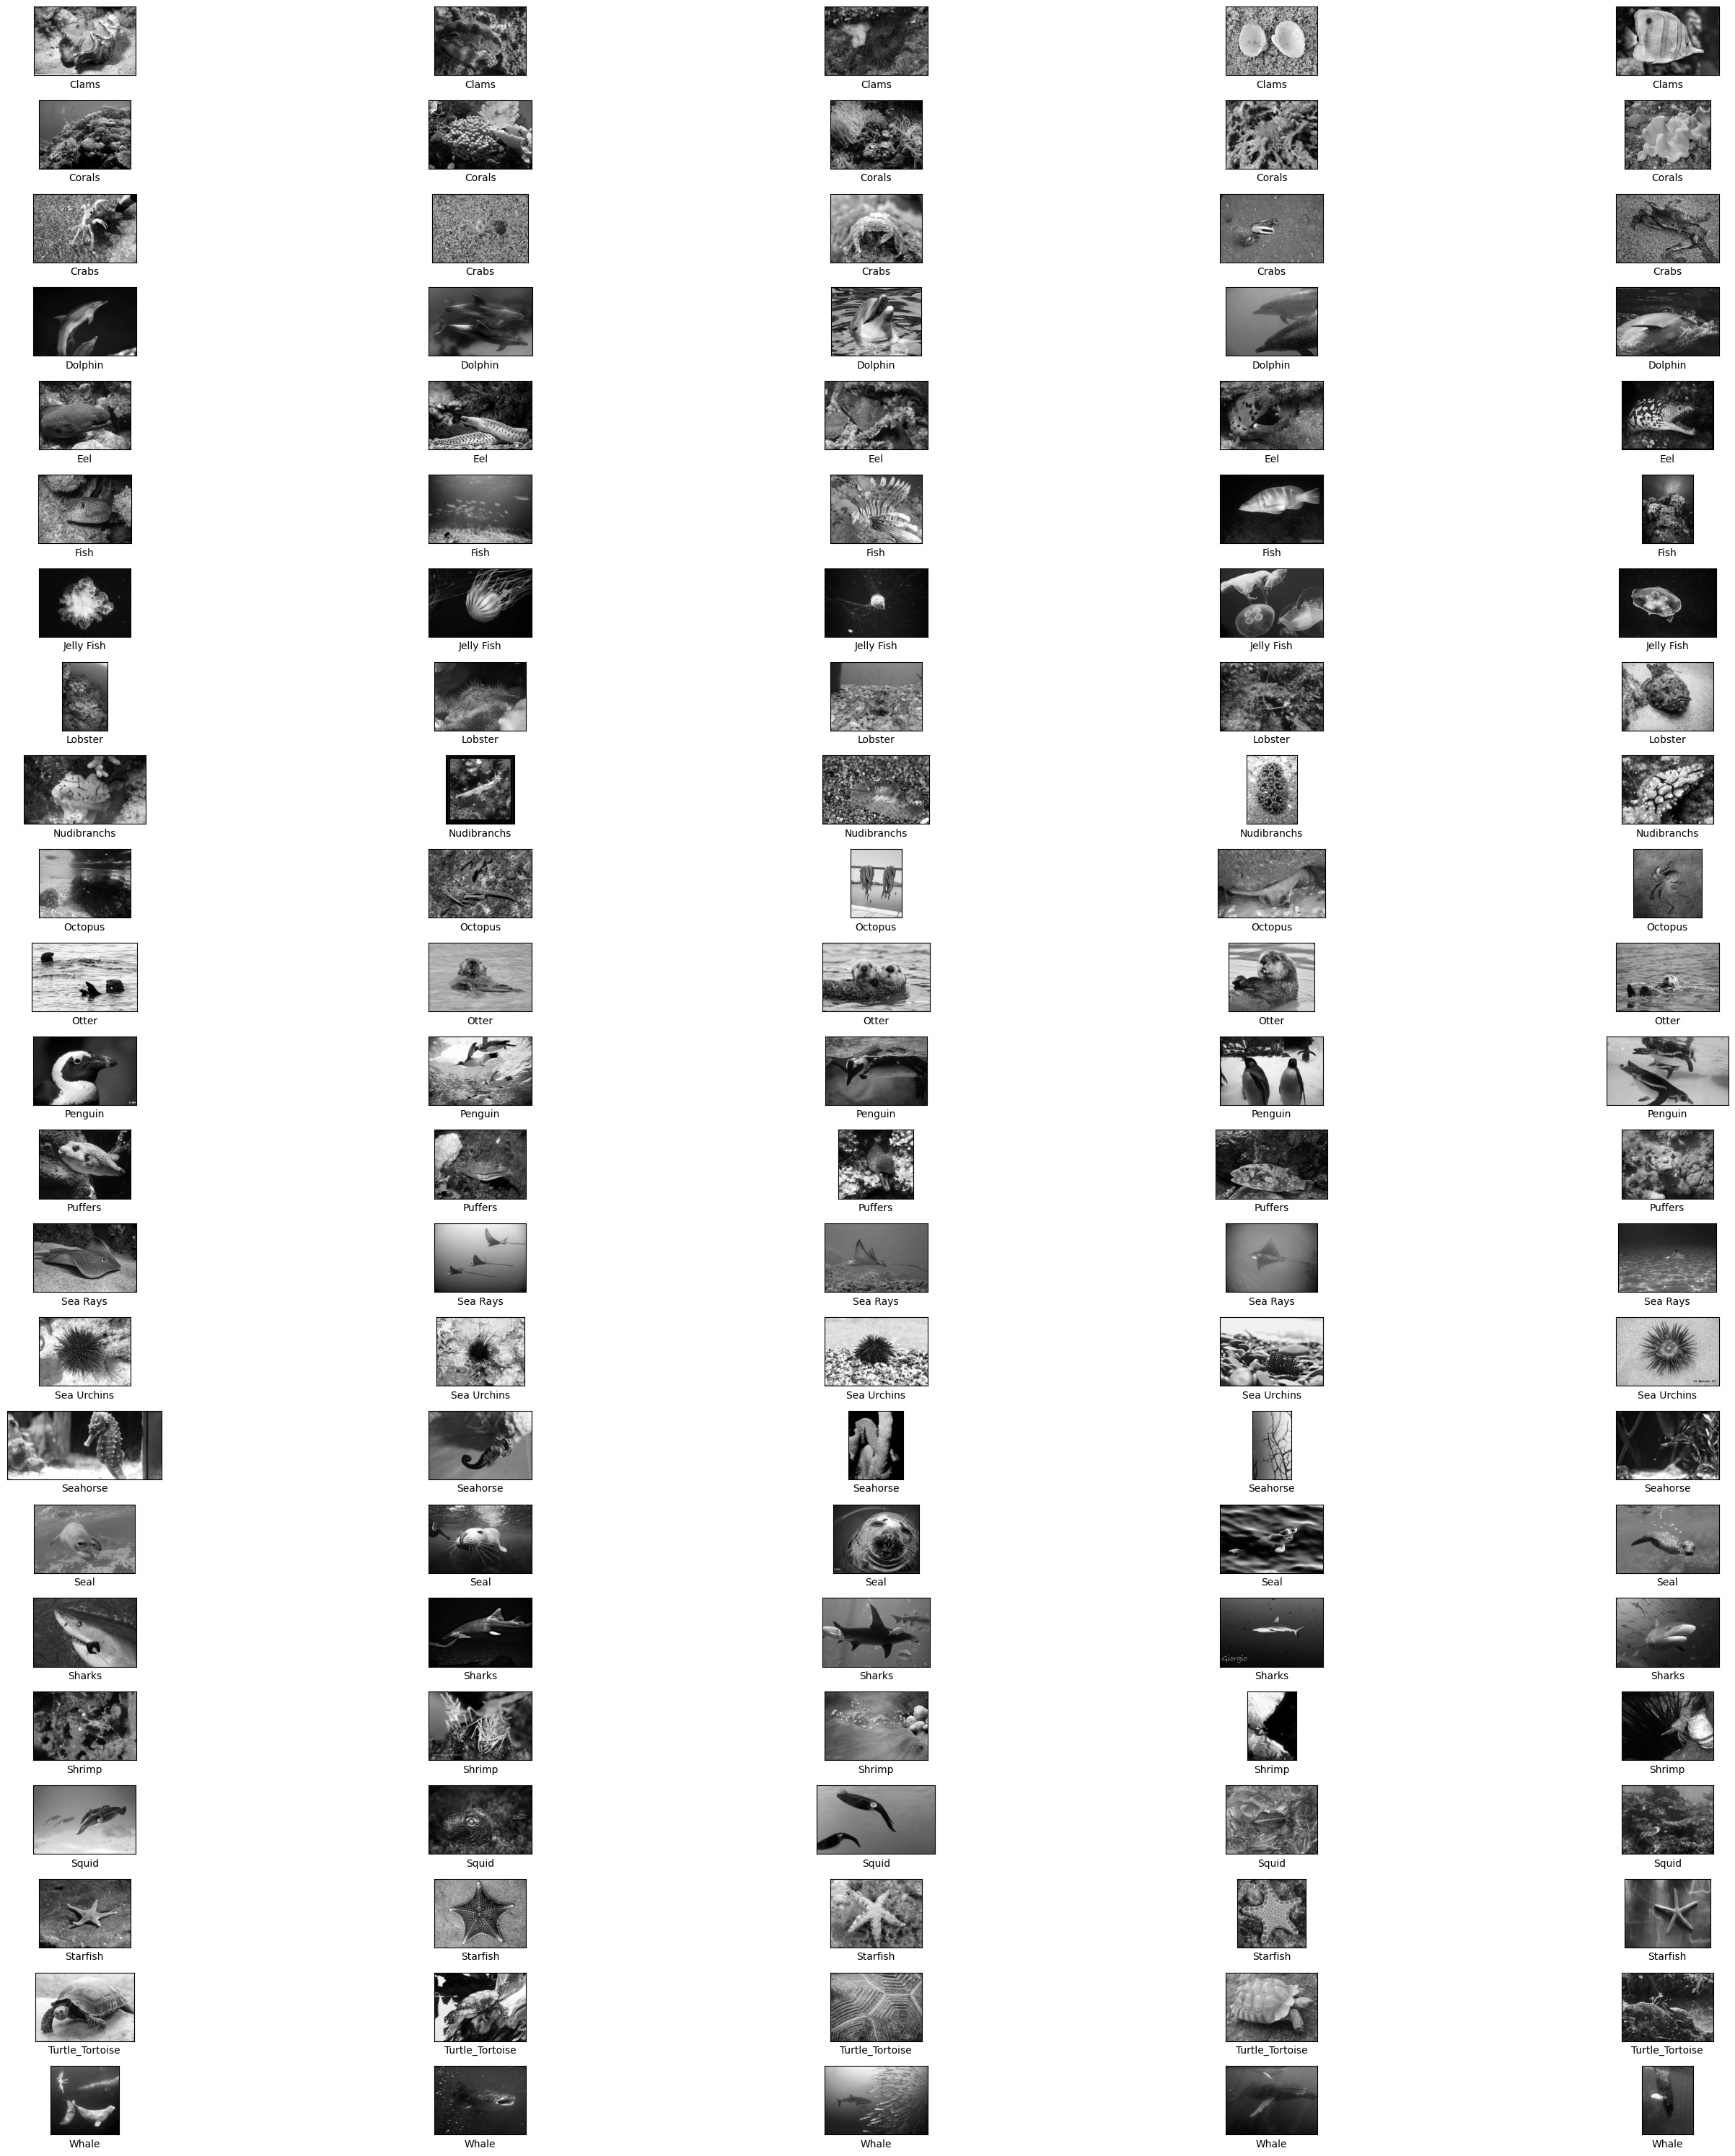

In [2]:
# Membuat kamus untuk menyimpan gambar setiap kelas dalam data
animals_image = {}

# Tentukan path sumber train
path = "../sea-animals-dataset/dataset/"
# path_sub = os.path.join(path "dataset")
for i in os.listdir(path):
    animals_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar setiap dari 16 kelas data
fig, axs = plt.subplots(len(animals_image.keys()), 5, figsize=(30, 30))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(animals_image[class_name], 5, replace=False)
    
    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L") # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

#### Plot Distribution 

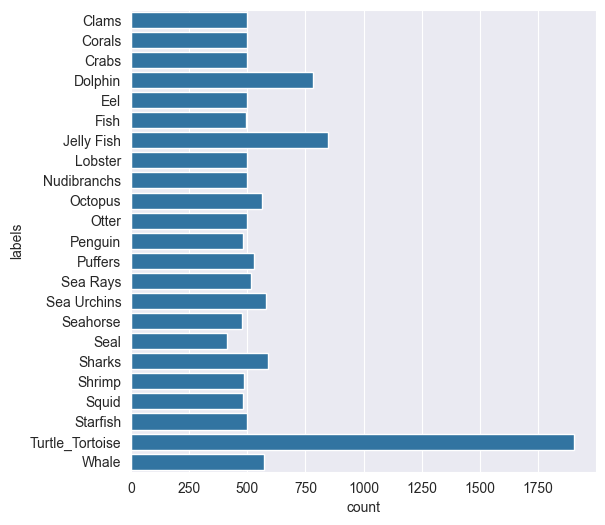

In [3]:
# Definisikan path sumber
animals_path = "../sea-animals-dataset/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(animals_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Data Augmentation

In [ ]:
#Membuat fungsi rotasi gambar yang dipakai pada fungsi rotasi lainnya
def rotate_image(img, angle):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return rotated

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    return rotate_image(img, random.randint(10, 90))

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    return rotate_image(img, -random.randint(10, 90))

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    return cv2.flip(img, 0)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[...,2] = cv2.add(hsv[...,2], 40)
    bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bright

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    blur = cv2.GaussianBlur(img, (3, 3), sigmaX=0.3)
    return blur

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    h, w = img.shape[:2]
    shear_factor = random.uniform(-0.1, 0.1)
    matrix = np.array([[1, shear_factor, 0],
                        [0, 1, 0]], dtype=np.float32)
    return cv2.warpAffine(img, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    h, w = img.shape[:2]
    shift_y = random.randint(-20, 20)
    matrix = np.array([[1, 0, 0],
                        [0, 1, shift_y]], dtype=np.float32)
    return cv2.warpAffine(img, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

# Membuat fungsi untuk melakukan perubahan ukuran gambar
def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

In [ ]:
# Definisikan fungsi-fungsi transformasi (pastikan sudah didefinisikan sebelumnya)
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

base_path = "../sea-animals-dataset/dataset"
target_per_class = 1700

class_image_paths = defaultdict(list)

# Buat daftar semua gambar dan simpan nama kelasnya
for class_name in os.listdir(base_path):
    class_dir = os.path.join(base_path, class_name)
    if os.path.isdir(class_dir):
        for im in os.listdir(class_dir):
            image_path = os.path.join(class_dir, im)
            class_image_paths[class_name].append(image_path)

# Augmentasi hanya untuk kelas dengan < 1700 gambar
for class_name, image_paths in class_image_paths.items():
    current_count = len(image_paths)
    print(f"Kelas '{class_name}': {current_count} gambar")

    if current_count >= target_per_class:
        print(f"> Lewati, sudah >= {target_per_class}\n")
        continue

    print(f"> Augmentasi diperlukan: {target_per_class - current_count} gambar\n")
    i = 1
    while current_count < target_per_class:
        image_path = random.choice(image_paths)

        try:
            image = io.imread(image_path)

            if image.ndim == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 4:
                image = image[:, :, :3]

            if image.dtype != np.uint8:
                image = img_as_ubyte(image)

            transformed = image.copy()
            num_transforms = random.randint(1, len(transformations))
            selected_transforms = random.sample(list(transformations), num_transforms)

            for key in selected_transforms:
                transformed = transformations[key](transformed)

            transformed = resize_image(transformed)

            if transformed.dtype != np.uint8:
                transformed = img_as_ubyte(transformed)
            transformed = cv2.cvtColor(transformed, cv2.COLOR_RGB2BGR)

            save_path = os.path.join(base_path, class_name, f"{class_name}_aug_{i}.jpg")
            cv2.imwrite(save_path, transformed)
            i += 1
            current_count += 1

        except Exception as e:
            print(f"  Gagal proses {image_path}: {e}, lanjut.")

print("\n✅ Augmentasi selesai. Semua kelas minimal memiliki 1700 gambar.")


Kelas 'Clams': 873 gambar
> Augmentasi diperlukan: 827 gambar

Kelas 'Corals': 500 gambar
> Augmentasi diperlukan: 1200 gambar

Kelas 'Crabs': 499 gambar
> Augmentasi diperlukan: 1201 gambar

Kelas 'Dolphin': 782 gambar
> Augmentasi diperlukan: 918 gambar

Kelas 'Eel': 497 gambar
> Augmentasi diperlukan: 1203 gambar

Kelas 'Fish': 494 gambar
> Augmentasi diperlukan: 1206 gambar

Kelas 'Jelly Fish': 845 gambar
> Augmentasi diperlukan: 855 gambar

Kelas 'Lobster': 499 gambar
> Augmentasi diperlukan: 1201 gambar

Kelas 'Nudibranchs': 500 gambar
> Augmentasi diperlukan: 1200 gambar

Kelas 'Octopus': 562 gambar
> Augmentasi diperlukan: 1138 gambar

Kelas 'Otter': 500 gambar
> Augmentasi diperlukan: 1200 gambar

Kelas 'Penguin': 482 gambar
> Augmentasi diperlukan: 1218 gambar

Kelas 'Puffers': 531 gambar
> Augmentasi diperlukan: 1169 gambar

Kelas 'Sea Rays': 517 gambar
> Augmentasi diperlukan: 1183 gambar

Kelas 'Sea Urchins': 579 gambar
> Augmentasi diperlukan: 1121 gambar

Kelas 'Seahorse

#### Plot Distribution After Augmentation

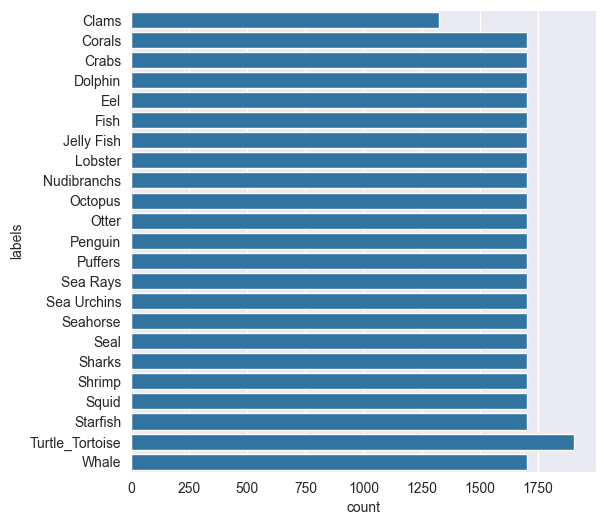

In [68]:
# Definisikan path sumber
animals_path = "../sea-animals-dataset/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(animals_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [73]:
# Panggil variabel mypath yang menampung folder dataset hasil augmentasi
mypath = "../sea-animals-dataset/dataset"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,"file_name":file_name,"labels":labels})
# Melihat jumlah data pada masing-masing label
df.groupby(['labels']).size()

labels
dataset\Clams              1324
dataset\Corals             1700
dataset\Crabs              1700
dataset\Dolphin            1700
dataset\Eel                1700
dataset\Fish               1700
dataset\Jelly Fish         1700
dataset\Lobster            1700
dataset\Nudibranchs        1700
dataset\Octopus            1700
dataset\Otter              1700
dataset\Penguin            1700
dataset\Puffers            1700
dataset\Sea Rays           1700
dataset\Sea Urchins        1700
dataset\Seahorse           1700
dataset\Seal               1700
dataset\Sharks             1700
dataset\Shrimp             1700
dataset\Squid              1700
dataset\Starfish           1700
dataset\Turtle_Tortoise    1903
dataset\Whale              1700
dtype: int64

In [74]:
# Variabel yang digunakan pada pemisahan data ini adalah x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300
) 

In [75]:
# Menyatukan ke masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test, 'labels':y_test,'set':'test'}) 

In [76]:
# Menggabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek data sampel
print(df_all.sample(5))

# Memanggil dataset yang berisi keseluruhan gambar yang sesuai dengan labelnya
datasource_path = "../sea-animals-dataset/dataset_augmented"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "../Dataset_Final/"


set    labels                 
test   dataset\Clams               238
       dataset\Corals              321
       dataset\Crabs               344
       dataset\Dolphin             329
       dataset\Eel                 354
       dataset\Fish                329
       dataset\Jelly Fish          360
       dataset\Lobster             354
       dataset\Nudibranchs         354
       dataset\Octopus             348
       dataset\Otter               350
       dataset\Penguin             340
       dataset\Puffers             332
       dataset\Sea Rays            348
       dataset\Sea Urchins         346
       dataset\Seahorse            344
       dataset\Seal                350
       dataset\Sharks              337
       dataset\Shrimp              322
       dataset\Squid               318
       dataset\Starfish            338
       dataset\Turtle_Tortoise     375
       dataset\Whale               355
train  dataset\Clams              1086
       dataset\Corals           

In [77]:
print(df_all.columns)


Index(['path', 'labels', 'set'], dtype='object')


In [79]:
for index, row in tq(df_all.iterrows()):
    # Ambil nama file
    image_name = os.path.basename(row['path'])
    class_name = os.path.basename(row['labels'])
    
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path, row['image'])

    # Buat direktori tujuan folder
    target_dir = os.path.join(dataset_path, row['set'], class_name)
    os.makedirs(target_dir, exist_ok=True)

    # Tentukan tujuan file
    file_dest = os.path.join(target_dir, image_name)

    # Salin file dari sumber ke tujuan
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

#### Image Data Generator

In [118]:
# Definisikan direktori training dan test
TRAIN_DIR = "../Dataset_Final/train/"
TEST_DIR = "../Dataset_Final/test/"

# Buat objek ImageDataGenerator yang menormalkan gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1/255., 
                                validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                batch_size=32,
                                                target_size=(150,150),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True)

validation_generator = val_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=32,
                                                    target_size=(150,150),
                                                    class_mode='categorical',
                                                    subset='validation',
                                                    shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                    batch_size=1,
                                                    target_size=(150,150),
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 31141 images belonging to 23 classes.
Found 6221 images belonging to 23 classes.
Found 7786 images belonging to 23 classes.


In [119]:
print(os.listdir("../Dataset_Final/"))
print(os.listdir("../Dataset_Final/test/"))
print(os.listdir("../Dataset_Final/train/"))

['test', 'train']
['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']
['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


## Modelling

In [120]:
####################### Init Transfer Learning Model with MobileNetV2 ##################################
# Load pretrained MobileNetV2 tanpa top layer (fully connected-nya)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True  # Freeze semua layer awal dulu

# Freeze layer bawah (opsional, misal hanya fine-tune bagian atas)
for layer in base_model.layers[:100]:
    layer.trainable = False

####################### Init sequential model ##################################
model_1 = Sequential()

# # ######################### Input layer with Fully Connected Layer ################################
# # 1st Convolutional layer, Batch Normalization layer, and Pooling layer
# model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling2D((2, 2)))
# model_1.add(Dropout(0.2))

# # 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
# model_1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling2D((2, 2)))
# model_1.add(Dropout(0.2))

# # 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
# model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling2D((2, 2)))
# model_1.add(Dropout(0.3))

# # 4rd Convolutional layer, Batch Normalization layer, and Pooling layer
# model_1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling2D((2, 2)))
# model_1.add(Dropout(0.3))

# Base Layer
model_1.add(base_model)

# Global Average Pooling
model_1.add(GlobalAveragePooling2D())

# 1nd Dense Layer
model_1.add(Dense(256, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => Output prediction untuk multi-class (23 kelas), gunakan softmax untuk mendapatkan probabilitas dari setiap kelas
model_1.add(Dense(23, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the Model Architecture
print(model_1.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_56 (Dense)            (None, 256)               327936    
                                                                 
 dropout_45 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 128)               32896     
                                                                 
 dropout_46 (Dropout)        (None, 128)             

In [ ]:
# Hitung jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(TRAIN_DIR):
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Hitung total semua gambar
total_images = sum(class_counts.values())
num_classes = len(class_counts)

# Hitung bobot per kelas
class_weights = {}
for idx, (class_name, count) in enumerate(class_counts.items()):
    class_weights[idx] = (1 / count) * (total_images / num_classes)
=-
# Tampilkan hasil
for idx, (label, weight) in enumerate(zip(class_counts.keys(), class_weights.values())):
    print(f"Label: {label:20s} | Weight: {weight:.4f}")

Label: Clams                | Weight: 1.2467
Label: Corals               | Weight: 0.9818
Label: Crabs                | Weight: 0.9985
Label: Dolphin              | Weight: 0.9876
Label: Eel                  | Weight: 1.0059
Label: Fish                 | Weight: 0.9876
Label: Jelly Fish           | Weight: 1.0104
Label: Lobster              | Weight: 1.0059
Label: Nudibranchs          | Weight: 1.0059
Label: Octopus              | Weight: 1.0014
Label: Otter                | Weight: 1.0029
Label: Penguin              | Weight: 0.9956
Label: Puffers              | Weight: 0.9897
Label: Sea Rays             | Weight: 1.0014
Label: Sea Urchins          | Weight: 1.0000
Label: Seahorse             | Weight: 0.9985
Label: Seal                 | Weight: 1.0029
Label: Sharks               | Weight: 0.9934
Label: Shrimp               | Weight: 0.9826
Label: Squid                | Weight: 0.9797
Label: Starfish             | Weight: 0.9941
Label: Turtle_Tortoise      | Weight: 0.8861
Label: Wha

In [122]:
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6)
]

# Fitting / training model
history_1 = model_1.fit(
    train_generator,
    epochs=50,
    batch_size=64,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
974/974 [==============================] - 674s 686ms/step - loss: 2.1563 - accuracy: 0.3696 - val_loss: 1.4504 - val_accuracy: 0.5944 - lr: 1.0000e-04
Epoch 2/50
974/974 [==============================] - 641s 658ms/step - loss: 1.4443 - accuracy: 0.5807 - val_loss: 0.8380 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 3/50
974/974 [==============================] - 541s 556ms/step - loss: 1.2120 - accuracy: 0.6494 - val_loss: 0.8184 - val_accuracy: 0.7581 - lr: 1.0000e-04
Epoch 4/50
974/974 [==============================] - 639s 656ms/step - loss: 1.0714 - accuracy: 0.6920 - val_loss: 1.0925 - val_accuracy: 0.7235 - lr: 1.0000e-04
Epoch 5/50
974/974 [==============================] - 562s 577ms/step - loss: 0.9687 - accuracy: 0.7219 - val_loss: 0.8164 - val_accuracy: 0.7828 - lr: 1.0000e-04
Epoch 6/50
974/974 [==============================] - 557s 571ms/step - loss: 0.8773 - accuracy: 0.7469 - val_loss: 0.5883 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 7/50
974/974 [==

## Evaluasi dan Visualisasi

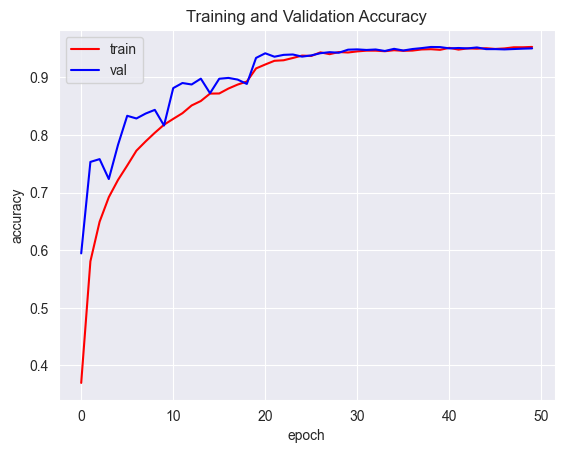

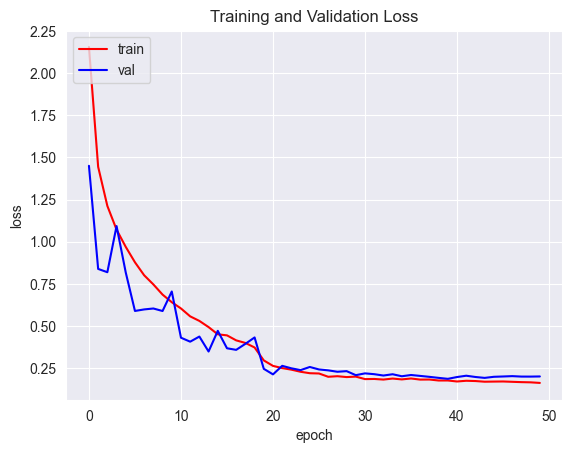

In [126]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

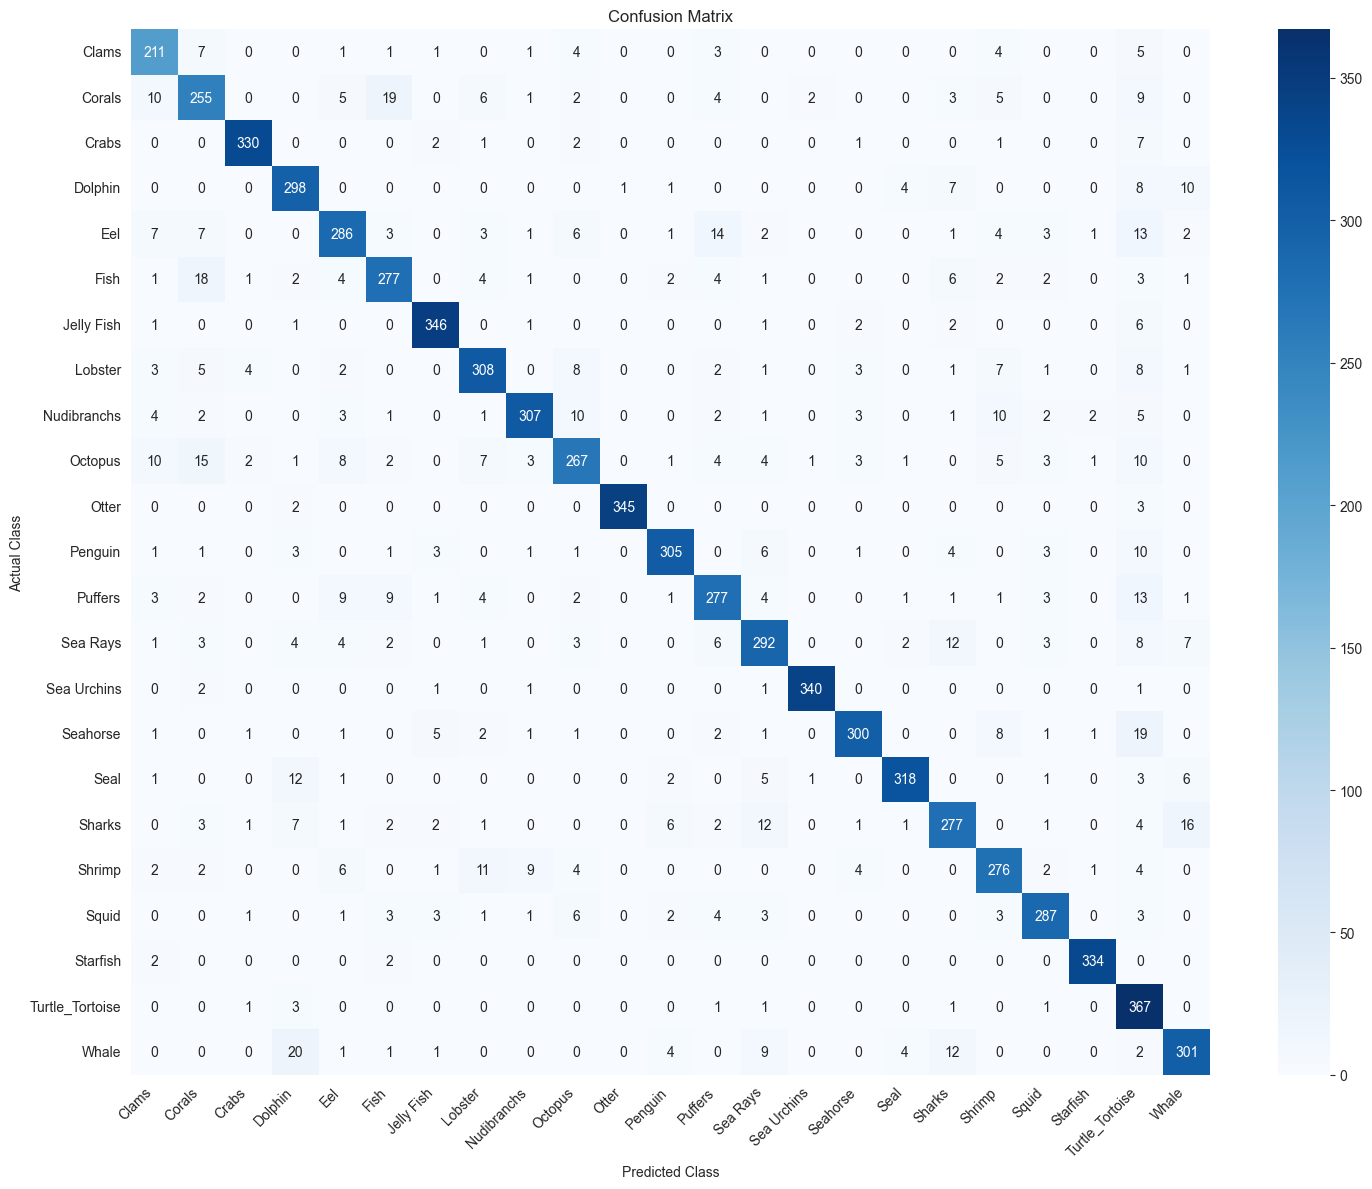


Classification Report:

                 precision    recall  f1-score   support

          Clams     0.8178    0.8866    0.8508       238
         Corals     0.7919    0.7944    0.7932       321
          Crabs     0.9677    0.9593    0.9635       344
        Dolphin     0.8442    0.9058    0.8739       329
            Eel     0.8589    0.8079    0.8326       354
           Fish     0.8576    0.8419    0.8497       329
     Jelly Fish     0.9454    0.9611    0.9532       360
        Lobster     0.8800    0.8701    0.8750       354
    Nudibranchs     0.9360    0.8672    0.9003       354
        Octopus     0.8449    0.7672    0.8042       348
          Otter     0.9971    0.9857    0.9914       350
        Penguin     0.9385    0.8971    0.9173       340
        Puffers     0.8523    0.8343    0.8432       332
       Sea Rays     0.8488    0.8391    0.8439       348
    Sea Urchins     0.9884    0.9827    0.9855       346
       Seahorse     0.9434    0.8721    0.9063       344
     

In [125]:
test_generator.reset()

preds_1 = model_1.predict(test_generator, verbose=0)
preds_1 = preds_1.copy()

# Ambil index kelas tertinggi dari softmax output → kelas prediksi
y_pred = np.argmax(preds_1, axis=1)
y_true = test_generator.classes

# Label nama kelas
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

## Konversi Model

In [127]:
model_1.save("saved_model/model.h5")

c:\Users\isnai\miniconda3\envs\main-ds\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
shutil.rmtree("C:/Users/isnai/miniconda3/envs/main-ds/Lib/site-packages/tensorflow_decision_forests", ignore_errors=True)

In [4]:
os.path.exists("C:/Users/isnai/miniconda3/envs/main-ds/Lib/site-packages/tensorflow_decision_forests")

False

In [5]:
!pip install tensorflow==2.15
!pip install tensorflow_decision_forests==1.8.1


  Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl.metadata (3.6 kB)
  Using cached tensorflow_intel-2.15.0-cp39-cp39-win_amd64.whl.metadata (5.1 kB)
Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.15.0-cp39-cp39-win_amd64.whl (300.8 MB)
   ---------------------------------------- 0.0/938.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/938.4 kB ? eta -:--:--
   --------------------------------- ------ 786.4/938.4 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 938.4/938.4 kB 3.9 MB/s eta 0:00:00

  Attempting uninstall: ml-dtypes

    Found existing installation: ml-dtypes 0.3.2

   ---------------------------------------- 0/3 [ml-dtypes]
    Uninstalling ml-dtypes-0.3.2:
   ---------------------------------------- 0/3 [ml-dtypes]
      Successfully uninstalled ml-dtypes-0.3.2
   ---------------------------------------- 0/3 [ml-dtypes]
   ---------------------------------------- 0/3 [ml-dtypes]

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 4.22.0 requires tensorflow-decision-forests>=1.5.0, which is not installed.


  Using cached tensorflow_decision_forests-1.8.1-cp39-cp39-win_amd64.whl


In [1]:
pip uninstall tensorflow_decision_forests -y

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
print(sys.executable)

c:\Users\isnai\miniconda3\envs\main-ds\python.exe


In [3]:
!pip list decision

Package                      Version
---------------------------- --------------
absl-py                      2.2.2
aiohappyeyeballs             2.6.1
aiohttp                      3.11.18
aiosignal                    1.3.2
altair                       5.5.0
anyio                        4.8.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
array-record                 0.4.1
arrow                        1.3.0
asn1crypto                   1.5.1
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                5.0.1
attrs                        25.1.0
Automat                      25.4.16
babel                        2.17.0
backcall                     0.2.0
backoff                      2.2.1
beautifulsoup4               4.13.3
bleach                       6.2.0
blinker                      1.9.0
cachetools                   5.5.2
certifi                      2025.4.26
cffi                         1.

In [6]:
# Install tensorflowjs
# !pip install tensorflow==2.15.0 tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-05-27 11:08:21.700751: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

Traceback (most recent call last):
  File "C:\Users\isnai\miniconda3\envs\main-ds\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\isnai\miniconda3\envs\main-ds\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\isnai\miniconda3\envs\main-ds\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\isnai\miniconda3\envs\main-ds\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\isnai\miniconda3\envs\main-ds\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.c

## Inference (Optional)